In [1]:
# ----------------------------------------
# 📦 Imports & Setup
# ----------------------------------------

import sys
sys.path.insert(0, "..")

import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.spatial.transform import Rotation as R

import torch
from torch.nn import functional as F

from app.vjepa_droid.transforms import make_transforms
from utils.mpc_utils import compute_new_pose

# Check CUDA
print(f"Cuda available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Cuda available: True


In [2]:
# ----------------------------------------
# 📂 Load Demo Data
# ----------------------------------------

pickle_path = '/data/maddie/predictive_safety_filters/demos/coffee_table/keyboard/1754005959.pickle'
with open(pickle_path, 'rb') as f:
    data = pickle.load(f)

print("Loaded keys:", data.keys())
print(f"Num Images (4fps): {len(data['images'])}")
print(f"Num cameras Angles: {len(data['images'][0])}")
print(f"Original image shape: {np.array(data['images'][0][0]).shape}")

Loaded keys: dict_keys(['state_dict', 'actions', 'images', 'ee_states'])
Num Images (4fps): 38
Num cameras Angles: 4
Original image shape: (1, 512, 512, 3)


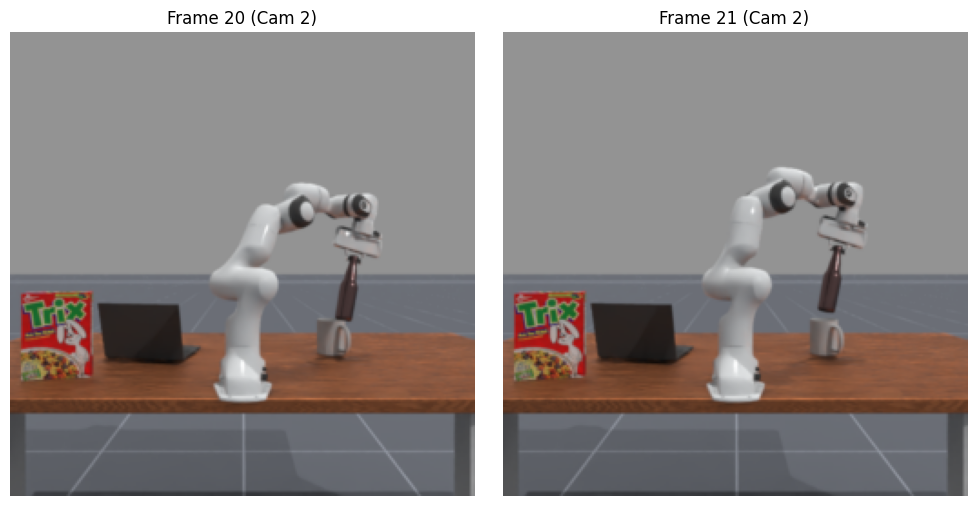

In [3]:
# ----------------------------------------
# 🖼️ Image Processing
# ----------------------------------------

def resize_image(img_array, size=(256, 256)):
    img_pil = Image.fromarray(img_array.astype(np.uint8))
    return np.array(img_pil.resize(size, resample=Image.BILINEAR))

camera_idx = 2
t_curr = 20

img_raw_t = data['images'][t_curr][camera_idx][0]
img_raw_t1 = data['images'][t_curr + 1][camera_idx][0]

img1 = resize_image(img_raw_t)
img2 = resize_image(img_raw_t1)

# Visualize
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img1); axs[0].set_title(f"Frame {t_curr} (Cam {camera_idx})")
axs[1].imshow(img2); axs[1].set_title(f"Frame {t_curr+1} (Cam {camera_idx})")
for ax in axs: ax.axis('off')
plt.tight_layout(); plt.show()

# Stack and normalize
np_imgs = np.stack([img1, img2], axis=0)  # (2, 256, 256, 3)
tensor_imgs = torch.tensor(np_imgs, dtype=torch.float32) / 255.0
tensor_imgs = tensor_imgs.permute(3, 0, 1, 2)  # [3, 2, 256, 256]
clips = tensor_imgs.unsqueeze(0).to(device)   # [1, 3, 2, 256, 256]

In [4]:
# ----------------------------------------
# 🤖 Action Processing
# ----------------------------------------

action = data["actions"][t_curr].unsqueeze(0).unsqueeze(0).to(device)  # [1, 1, 7]


In [5]:
# ----------------------------------------
# 🤖 State Processing
# ----------------------------------------

# Convert EE state from quaternion to 7D (position, euler, gripper)
ee_states_np = np.stack(data["ee_states"])  # (T, 8)
positions = ee_states_np[:, :3]
quaternions = ee_states_np[:, 3:7]
grippers = ee_states_np[:, 7:]
eulers = R.from_quat(quaternions).as_euler('xyz', degrees=False)
ee_states_7d_np = np.concatenate([positions, eulers, grippers], axis=1)
ee_states_7d = torch.tensor(ee_states_7d_np, dtype=torch.float32).to(device)  # (T, 7)

state = ee_states_7d[t_curr].unsqueeze(0).unsqueeze(0).to(device)  # [1, 1, 7]

In [6]:
# ----------------------------------------
# ⚙️ Load V-JEPA 2 Model
# ----------------------------------------

encoder, predictor = torch.hub.load("facebookresearch/vjepa2", "vjepa2_ac_vit_giant")
encoder = encoder.to(device)
predictor = predictor.to(device)

crop_size = 256
patch_size = encoder.patch_size
tokens_per_frame = (crop_size // patch_size) ** 2

print(f"Patch size: {patch_size}, Tokens per frame: {tokens_per_frame}")

Using cache found in /home/maddie/.cache/torch/hub/facebookresearch_vjepa2_main
/home/maddie/.conda/envs/vjepa2/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Patch size: 16, Tokens per frame: 256


In [7]:
# ----------------------------------------
# 🔄 Encoding & Prediction
# ----------------------------------------

def forward_target(c, normalize_reps=True):
    B, C, T, H, W = c.size()
    c = c.permute(0, 2, 1, 3, 4).flatten(0, 1).unsqueeze(2).repeat(1, 1, 2, 1, 1)
    h = encoder(c)
    h = h.view(B, T, -1, h.size(-1)).flatten(1, 2)
    return F.layer_norm(h, (h.size(-1),)) if normalize_reps else h

def step_predictor(z_hat, a_hat, s_hat, normalize_reps=False):
    z_hat = predictor(z_hat, a_hat, s_hat)[:, -tokens_per_frame:]
    if normalize_reps:
        z_hat = F.layer_norm(z_hat, (z_hat.size(-1),))
    s_hat = compute_new_pose(s_hat[:, -1:], a_hat[:, -1:])
    return z_hat, s_hat

def loss_fn(z, h):
    z = z[:, -tokens_per_frame:]
    h = h[:, -tokens_per_frame:]
    return torch.mean(torch.abs(z - h), dim=[1, 2])

# Encode and predict
start_time = time.time()
h = forward_target(clips)
z_next_pred, s_hat = step_predictor(h[:, :tokens_per_frame], action, state)
end_time = time.time()

print(f"Prediction time: {end_time - start_time:.4f} seconds")


Prediction time: 0.3401 seconds


/home/maddie/.conda/envs/vjepa2/lib/python3.12/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


In [ ]:
# ----------------------------------------
# 📉 Evaluation
# ----------------------------------------

loss = loss_fn(z_next_pred, h[:, tokens_per_frame:])
cos_sim = F.cosine_similarity(z_next_pred, h[:, tokens_per_frame:], dim=-1).mean().item()
mse_loss = torch.nn.functional.mse_loss(s_hat, state)
print(f"MSE in state prediction: {mse_loss.item():.4f}")
print(f"Prediction L1 Loss: {loss.item():.4f}")
print(f"Cosine Similarity: {cos_sim:.4f}")

MSE loss in state prediction: 0.0011
Prediction L1 Loss: 0.5285
Cosine Similarity: 0.7384


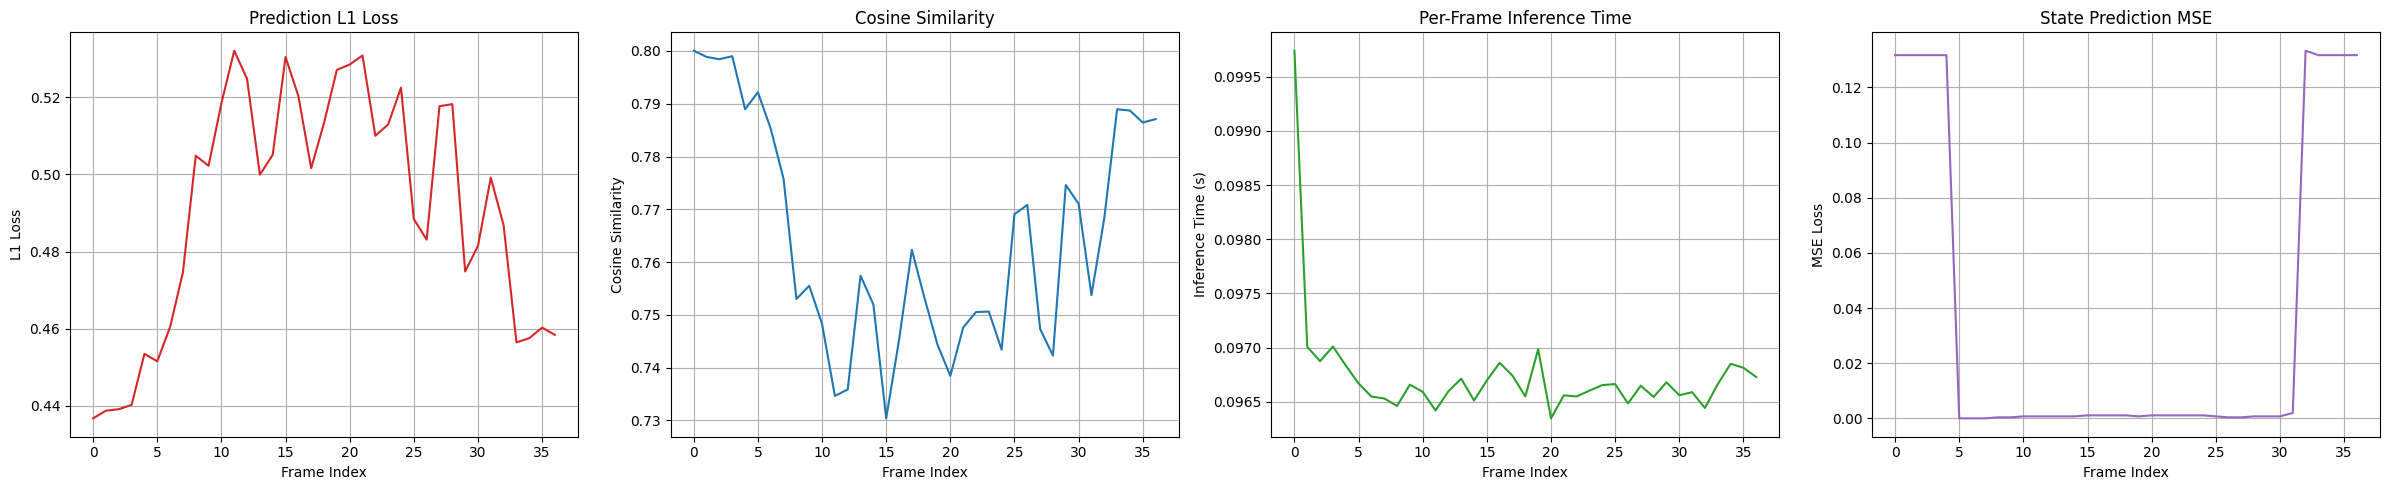

In [14]:
# ----------------------------------------
# 🔁 Loop Through All Image Pairs w/ Inference Timing
# ----------------------------------------

l1_losses = []
cos_sims = []
mse_losses = []
inference_times = []
frame_indices = []

camera_idx = 2  # Change if needed

for t_curr in range(len(data["images"]) - 1):
    try:
        # ------------------------------
        # Image preprocessing
        # ------------------------------
        img_t = resize_image(data["images"][t_curr][camera_idx][0])
        img_t1 = resize_image(data["images"][t_curr + 1][camera_idx][0])
        
        np_imgs = np.stack([img_t, img_t1], axis=0)
        tensor_imgs = torch.tensor(np_imgs, dtype=torch.float32) / 255.0
        tensor_imgs = tensor_imgs.permute(3, 0, 1, 2)  # [3, 2, 256, 256]
        clips = tensor_imgs.unsqueeze(0).to(device)   # [1, 3, 2, 256, 256]

        # ------------------------------
        # Actions and EE state
        # ------------------------------
        action = data["actions"][t_curr].unsqueeze(0).unsqueeze(0).to(device)
        state = ee_states_7d[t_curr].unsqueeze(0).unsqueeze(0).to(device)

        # ------------------------------
        # Encode and Predict (timed)
        # ------------------------------
        start_time = time.time()
        h = forward_target(clips)
        z_next_pred, s_hat = step_predictor(h[:, :tokens_per_frame], action, state)
        end_time = time.time()

        inference_time = end_time - start_time

        # ------------------------------
        # Metrics
        # ------------------------------
        l1 = loss_fn(z_next_pred, h[:, tokens_per_frame:])
        cos = F.cosine_similarity(z_next_pred, h[:, tokens_per_frame:], dim=-1).mean().item()
        mse = torch.nn.functional.mse_loss(s_hat, state)

        # Store results
        l1_losses.append(l1.item())
        cos_sims.append(cos)
        mse_losses.append(mse.item())
        inference_times.append(inference_time)
        frame_indices.append(t_curr)

    except Exception as e:
        print(f"⚠️ Skipping frame {t_curr} due to error: {e}")
        continue

# ----------------------------------------
# 📊 Plot Metrics
# ----------------------------------------

plt.figure(figsize=(24, 5))  # Make space for 4 plots

plt.subplot(1, 4, 1)
plt.plot(frame_indices, l1_losses, color='tab:red')
plt.xlabel("Frame Index")
plt.ylabel("L1 Loss")
plt.title("Prediction L1 Loss")
plt.grid(True)

plt.subplot(1, 4, 2)
plt.plot(frame_indices, cos_sims, color='tab:blue')
plt.xlabel("Frame Index")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity")
plt.grid(True)

plt.subplot(1, 4, 3)
plt.plot(frame_indices, inference_times, color='tab:green')
plt.xlabel("Frame Index")
plt.ylabel("Inference Time (s)")
plt.title("Per-Frame Inference Time")
plt.grid(True)

plt.subplot(1, 4, 4)
plt.plot(frame_indices, mse_losses, color='tab:purple')
plt.xlabel("Frame Index")
plt.ylabel("MSE Loss")
plt.title("State Prediction MSE")
plt.grid(True)

plt.tight_layout()
plt.show()